# 示例：充电站布置

确定建设新的电动汽车充电站的最佳位置是一个复杂的优化问题。需要考虑许多因素，如现有的充电桩位置、兴趣点（POIs）、要建设的数量等。在这个示例中，我们将看看如何制定这个优化问题并使用Dynex神经形态平台来解决它。

## 问题描述

有许多不同的电动汽车充电桩布局问题的变种可能被考虑。对于这个演示，我们考虑的情况是在一个小区域内进行考虑，所有在考虑区域内的地点都可以步行到达。在这种情况下，我们希望放置新的充电位置，以便对所有POIs都方便。例如，如果POIs是主要街道上的商店，那么在一个中心位置停车最为便利。我们将通过考虑从潜在的新充电站到所有POIs的平均距离来满足这一需求。此外，我们希望将新的充电桩放置在已有的和其他新的充电位置之外，以减少重叠并最大程度地覆盖该区域。

这个问题可以被视为包含4个独立约束（或目标）的问题，其中二进制变量表示每个潜在的新充电站位置。

## 最小化与POIs的距离 

对于每个潜在的新充电站位置，我们计算到地图上所有POIs的平均距离。使用这个值作为每个二进制变量的线性偏差，我们的程序会更倾向于那些（平均而言）靠近POIs的位置。请注意，这个约束可以根据问题的实际情况替换为其他约束。

## 最大化到现有充电站的距离

对于每个潜在的新充电站位置，我们计算它们到地图上所有现有充电站的平均距离。通过将这个值的负值作为每个二进制变量的线性偏置，我们的程序将更倾向于选择那些距离现有充电站（平均而言）较远的位置。

## 最大化与其他新充电站的距离

对于新充电站位置的一对，我们希望最大化它们之间的距离。为了实现这一目标，我们考虑了所有可能的位置配对，并计算它们之间的距离。通过将这个值的负数作为相应二进制变量的乘积的二次偏差，我们的程序将更倾向于选择相互距离较远的位置。

## 建造正好两个新的充电站

为了选择正好两个新的充电站，我们使用dimod.generators.combinations函数。这个函数在dimod包中将我们的二进制变量（bqm.variables）中的正好num_new_cs个设置为值1，并为这个约束应用一个强度（gamma4）。有关可调强度参数的更多信息，请参见下文。

## 参数调优 

每个这些约束都以一个系数（名称都以gamma开头）的形式构建到我们的BQM对象中。这个术语gamma被称为拉格朗日参数，它可以用来调整约束之间的权重，以准确反映问题的要求。根据您的问题要求和规模，您可能希望调整这个参数。在这个程序中设置的值被选择为经验性地适用于各种规模的问题的起点。

# 执行

首先，我们加载所需的包：

In [1]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import dynex
import dimod

我们创建了一些辅助函数来根据网格的宽度和高度以及兴趣点的数量和现有充电站的数量来设置场景：

In [2]:
def set_up_scenario(w, h, num_poi, num_cs):
    """
    建立具有指定参数的场景设置。

    参数：

        w（整数）：网格的宽度
        h（整数）：网格的高度
        num_poi（整数）：感兴趣点的数量
        num_cs（整数）：现有充电站的数量
    返回值：

        G（networkx图）：大小为w乘以h的网格图
        pois（整数元组列表）：一组固定的感兴趣点
        charging_stations（整数元组列表）：当前充电位置的集合
        potential_new_cs_nodes（整数元组列表）：潜在的新充电位置
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # 确定一个固定的感兴趣点集合
    pois = random.sample(nodes, k=num_poi)

    # 确定一组固定的当前充电位置
    charging_stations = random.sample(nodes, k=num_cs)

    # 确定潜在的新充电位置
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes

The distance function returns the distance between two coordinates:

In [3]:
def distance(a, b):
    return (a[0]**2 - 2*a[0]*b[0] + b[0]**2) + (a[1]**2 - 2*a[1]*b[1] + b[1]**2)

The following function builds a binary quadratic model (bqm) from our problem scenario:

In [4]:
def build_bqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs):
    """
    构建模拟我们问题场景的BQM（二进制二次模型）

    参数：

        potential_new_cs_nodes（整数元组列表）：潜在的新充电位置
        num_poi（整数）：感兴趣点的数量
        pois（整数元组列表）：一组固定的感兴趣点
        num_cs（整数）：现有充电站的数量
        charging_stations（整数元组列表）：当前充电位置的集合
        num_new_cs（整数）：所需的新充电站数量
    返回值：

        bqm_np（BinaryQuadraticModel）：输入场景的QUBO模型
    """

    # 可调参数
    gamma1 = len(potential_new_cs_nodes) * 4
    gamma2 = len(potential_new_cs_nodes) / 3
    gamma3 = len(potential_new_cs_nodes) * 1.7
    gamma4 = len(potential_new_cs_nodes) ** 3

    # 使用邻接向量（adjVectors）构建BQM，以找到最佳的新充电位置，以满足最小化条件。
    # 距离感兴趣点的最小距离和距离现有充电位置的最大距离。
    bqm = dimod.BinaryQuadraticModel(len(potential_new_cs_nodes), 'BINARY')

    # 约束1：感兴趣点的最小平均距离
    if num_poi > 0:
        for i in range(len(potential_new_cs_nodes)):
            # 计算从此节点到感兴趣点的平均距离
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = sum(distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * gamma1

    # 约束2：距离现有充电器的最大距离
    if num_cs > 0:
        for i in range(len(potential_new_cs_nodes)):
            # 计算从该节点到感兴趣点的平均距离。
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = -sum(distance(cand_loc, loc)
                            for loc in charging_stations) / num_cs
            bqm.linear[i] += avg_dist * gamma2

    # 约束3：距离其他新充电站的最大距离。
    if num_new_cs > 1:
        for i in range(len(potential_new_cs_nodes)):
            for j in range(i+1, len(potential_new_cs_nodes)):
                ai = potential_new_cs_nodes[i]
                aj = potential_new_cs_nodes[j]
                dist = -distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma3)

    # 约束4：选择正好num_new_cs个新充电位置
    bqm.update(dimod.generators.combinations(bqm.variables, num_new_cs, strength=gamma4))

    return bqm

Next we define a function to retrieve the results in the terminal output:

In [5]:
def printout_solution_to_cmdline(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs):
    """
    将解决方案统计信息打印到命令行。

    参数：

        pois（整数元组列表）：一组固定的感兴趣点
        num_poi（整数）：感兴趣点的数量
        charging_stations（整数元组列表）：一组固定的当前充电位置
        num_cs（整数）：现有充电站的数量
        new_charging_nodes（整数元组列表）：新充电站的位置
        num_new_cs（整数）：所需的新充电站数量
    返回值：

        无。
    """

    print("\nSolution returned: \n------------------")

    print("\nNew charging locations:\t\t\t\t", new_charging_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_charging_nodes)
        for loc in pois:
            for i, new in enumerate(new_charging_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_cs > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in charging_stations) / num_cs for new in new_charging_nodes]
        print("Average distance to old charging stations:\t", old_cs_avg_dist)

    if num_new_cs > 1:
        new_cs_dist = 0
        for i in range(num_new_cs):
            for j in range(i+1, num_new_cs):
                new_cs_dist += abs(new_charging_nodes[i][0]-new_charging_nodes[j][0])+abs(new_charging_nodes[i][1]-new_charging_nodes[j][1])
        print("Distance between new chargers:\t\t\t", new_cs_dist)

We also want to create an output image of the solution scenario. Black nodes represent available space, red nodes the current charger locations, nodes marked "P" the Point of Interest (POI) locations and finally blue nodes the new charger locations:

In [6]:
def save_output_image(G, pois, charging_stations, new_charging_nodes):
    """ 
    
    创建解决方案场景的输出图像。

        黑色节点：可用空间
        红色节点：当前充电器位置
        标有 'P' 的节点：POI 位置
        蓝色节点：新充电站位置
    参数：

        G（networkx图）：大小为w乘以h的网格图
        pois（整数元组列表）：一组固定的感兴趣点
        charging_stations（整数元组列表）：一组固定的当前充电位置
        new_charging_nodes（整数元组列表）：新充电站的位置
    返回值：

        无。输出保存到文件 "map.png"。
        
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New EV Charger Locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # 在地图上标识感兴趣点（POIs）
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # 在地图上标识旧的充电站。
    cs_graph = G.subgraph(charging_stations)

    # 在地图上将旧的充电站定位在感兴趣点（POIs）处。
    poi_cs_list = set(pois) - (set(pois)-set(charging_stations))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # 绘制旧地图（左侧图像）。
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # 绘制新地图（右侧图像）
    new_cs_graph = G.subgraph(new_charging_nodes)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')

    # 保存图像
    plt.savefig("map.png")

## 设置参数

在我们的示例中，我们定义一个尺寸为15 x 15的网格，包含三个感兴趣点（POI）。我们还放置了四个现有的充电站，并希望确定两个新的充电站：

In [7]:
w = 15 # 网格的宽度
h = 15 # 网格的高度
num_poi = 3 # 感兴趣点的数量
num_cs = 4 # 现有充电站的数量
num_new_cs = 2 # 要放置的新充电站数量

然后我们构建了城市的大型网格图：

In [8]:
# 构建城市的大型网格图。
G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(w, h, num_poi, num_cs)

然后调用函数构建BQM：

In [9]:
# 构建 BQM
bqm = build_bqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs)

要在Dynex神经形态计算平台上运行BQM，我们创建Dynex采样器：

In [10]:
# 在Dynex上运算
model = dynex.BQM(bqm);
sampler = dynex.DynexSampler(model);

[DYNEX] MODEL CONVERTED TO QUBO
[ÐYNEX] PRECISION CUT FROM 1000.0 TO 1
[DYNEX] PRECISION SET TO 1
[DYNEX] QUBO: Constant offset of the binary quadratic model: 43175444.0


我们将模型提交到Dynex平台，并指定在100个积分步骤之后从1024个Dynex芯片中读取数据：

In [11]:
sampleset = sampler.sample(num_reads=1024, annealing_time = 100);
ss = sampler.dimod_assignments.first.sample;

[DYNEX|508] 0.29s #workers: 1 #chips: 1024 #steps: 100 global falsified softs: 220 global energy: 7097678632.0
[DYNEX] FINISHED READ AFTER 0.29 SECONDS
[DYNEX] SAMPLESET LOADED
[DYNEX] MALLOB: JOB UPDATED: 508


具有最低能量的样本被存储在变量 'ss' 中，现在我们将其应用：

In [12]:
new_charging_nodes = [potential_new_cs_nodes[k] for k, v in ss.items() if v == 1]

我们打印并绘制要放置的新充电站的结果：

In [13]:
# 将结果打印到命令行供用户查看。
printout_solution_to_cmdline(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs)


Solution returned: 
------------------

New charging locations:				 [(11, 5), (3, 8)]
Average distance to POIs:			 [9.666666666666666, 10.0]
Average distance to old charging stations:	 [10.0, 15.0]
Distance between new chargers:			 11


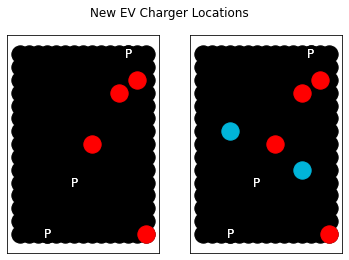

In [14]:
# 创建场景输出图像
save_output_image(G, pois, charging_stations, new_charging_nodes)

## 参考文献

[1] Pagany, Raphaela, Anna Marquardt, and Roland Zink. "《电动汽车充电需求位置模型—基于用户和目的地的电动汽车充电站定位方法》" Sustainability 11.8 (2019): 2301. https://doi.org/10.3390/su11082301